In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Simulation notes
For the simulation, the time is following this convention:
1 time unit = 10 ms


In [24]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) - z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))

# Parameters
parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.15, 'r':0.00005, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

# sim parameters
dt = 0.001
t_sim_init = 100
n_samples_init = int(t_sim_init/dt)
t_sim = 4000
n_samples = int(t_sim/dt)
upsamp = 100
t = np.linspace(0, t_sim, t_sim*upsamp)

# stim parameters
t_start = 100
Is1 = 2
Is2 = 5
I_duration = .3
I_inter = 5 - I_duration
n_stim = 400

lx0 = np.arange(-1.6, -2.3, -0.02)# [-2.2, -2.25, -2.3]
llq, lte = [], []
for x0 in lx0:
    print(x0)
    stim = 1
    parameters['x0'] = x0

    # Find initial conditions by root solving
    q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
    q = fsolve(epileptor, q0, args=parameters)

    for it in range(n_samples_init):
        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)


    lq = []
    for it in range(n_samples):
        # if it%10000==0:
        #     print(it)
        tc = it*dt
        if q[0]>-.5 and stim:
            stim = 0 # no stim after a seizure
            lte.append(tc*upsamp)

        tstim = 0
        if stim:
            for i_stim in range(n_stim):
                if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                    tstim = 1
        if tstim:
            parameters['Is2'] = Is2
            parameters['Is1'] = Is1
        else:
            parameters['Is2'] = 0
            parameters['Is1'] = 0

        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)

        if it%int(1/(upsamp*dt))==0:
            lq.append(q.copy())
    llq.append(lq)

llq = np.array(llq)

-1.6


/home/tim/anaconda3/envs/main/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The number of calls to function has reached maxfev = 1400.
  warnings.warn(msg, RuntimeWarning)


-1.62
-1.6400000000000001
-1.6600000000000001
-1.6800000000000002
-1.7000000000000002
-1.7200000000000002
-1.7400000000000002
-1.7600000000000002
-1.7800000000000002
-1.8000000000000003
-1.8200000000000003
-1.8400000000000003
-1.8600000000000003
-1.8800000000000003
-1.9000000000000004
-1.9200000000000004
-1.9400000000000004
-1.9600000000000004
-1.9800000000000004
-2.0000000000000004
-2.0200000000000005
-2.0400000000000005
-2.0600000000000005
-2.0800000000000005
-2.1000000000000005
-2.1200000000000006
-2.1400000000000006
-2.1600000000000006
-2.1800000000000006
-2.2000000000000006
-2.2200000000000006
-2.2400000000000007
-2.2600000000000007
-2.2800000000000007


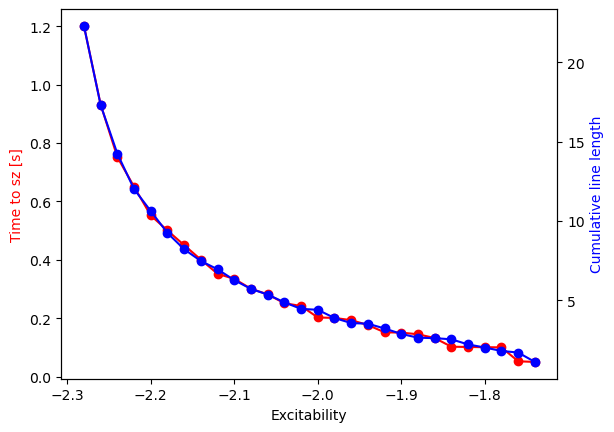

In [64]:
ts = -llq[7:, :, 0] + llq[7:, :, 3]
time_sz, cumll = [], []
for ix0, x0 in enumerate(lx0[7:]):
    # ix0 = 2-ix0 # to reverse the order of plotting
    try:
        t_stim_onsets = []
        tstart_sz = np.nonzero(llq[7+ix0, :, 0]>-.5)[0][0]
        # print(lte[ix0])
        for i_stim in range(n_stim):
            tc = (t_start + i_stim*I_duration + i_stim*I_inter)*upsamp
            # if tc<lte[ix0]:#-1000:
            if tc<tstart_sz:#-1000:
                t_stim_onsets.append(tc)
                end_stim = i_stim

        dif = []
        for istim in range(len(t_stim_onsets)):
            # dif.append(np.sum(np.abs(np.diff(ts[in_stim, int(t_stim_onsets[istim]+0*upsamp):int(t_stim_onsets[istim]+5*upsamp)]))))
            dif.append(np.sum(np.abs(np.diff(ts[ix0, int(t_stim_onsets[istim]+0.*upsamp):int(t_stim_onsets[istim]+.25*upsamp)]))))

        dif_6d = []
        for istim in range(len(t_stim_onsets)):
            for idim in range(6):
                qc = llq[7+ix0, int(t_stim_onsets[istim]):int(t_stim_onsets[istim]+25*upsamp), idim]
                dif_6d.append(np.sum(np.abs(np.diff(qc))))

        dif_6dr = np.reshape(dif_6d, (len(t_stim_onsets), 6))

        cumll.append(np.sum(dif))
        time_sz.append(lte[7+ix0] - t_start*upsamp)
    except:
        print('no sz')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
ax1.scatter(lx0[7:], np.array(time_sz)/(upsamp*100), c='r')
ax1.plot(lx0[7:], np.array(time_sz)/(upsamp*100), 'r')
ax2.scatter(lx0[7:], cumll, c='b')
ax2.plot(lx0[7:], cumll, 'b')
ax1.set_xlabel('Excitability')
ax1.set_ylabel('Time to sz [s]', color='r')
ax2.set_ylabel('Cumulative line length', color='b')
plt.savefig('Time_sz_cum_LL_diff_exc.svg')